In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import shap

import matplotlib.pyplot as plt

np.random.seed(42)

c:\Anaconda\envs\ai4good\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
years = np.array(range(2012, 2024))
features = ["18 to 64 years poverty [%]", "18 years and over [%]",
    "65 years and over [%]", "65 years and over poverty [%]",
    "All parents in family in labor force [%]",
    "American Indian and Alaska Native [%]", "Armed Forces [%]",
    "Asian [%]", "Black or African American [%]",
    "Civilian labor force [%]", "Commuting: individual car [%]",
    "Commuting: public transport [%]", "Commuting: work from home [%]",
    "Education: 9th-12th (no diploma) [%]", "Education: <9th grade [%]",
    "Education: associate's degree [%]", "Education: bachelor's degree [%]",
    "Education: bachelor's degree or higher [%]",
    "Education: graduate or professional degree [%]",
    "Education: high school graduate [%]",
    "Education: high school graduate or higher [%]",
    "Education: some college (no degree) [%]",
    "Female civilian labor force [%]", "Foreign-born [%]",
    "Foreign-born: naturalized [%]", "Gross rent <25% of income [%]",
    "Gross rent >=25% of income [%]",
    "Health insurance coverage [%]",
    "Hispanic or Latino [%]", "Homeowner vacancy rate [%]",
    "Households: Female (no spouse) [%]",
    "Households: Male (no spouse) [%]", "Households: married-couple [%]",
    "Households: with broadband [%]", "Households: with computer [%]",
    "Housing units with a mortgage [%]",
    "Labor force by industry: agriculture, forestry, fishing, hunting, mining [%]",
    "Labor force by industry: arts, entertainment, recreation, accommodation, food services [%]",
    "Labor force by industry: construction [%]",
    "Labor force by industry: education, health care, social assistance [%]",
    "Labor force by industry: finance, insurance, real estate, rental, leasing [%]",
    "Labor force by industry: information [%]",
    "Labor force by industry: manufacturing [%]",
    "Labor force by industry: other services [%]",
    "Labor force by industry: professional, scientific, management, admin, waste management services [%]",
    "Labor force by industry: public administration [%]",
    "Labor force by industry: retail trade [%]",
    "Labor force by industry: transportation, warehousing, utilities [%]",
    "Labor force by industry: wholesale trade [%]", "Land area (km²)",
    "Limited English speakers [%]", "Male [%]",
    "Mean travel time to work (min)", "Median age",
    "Median full-time earnings gender ratio (F/M) [%]",
    "Median household income ($)", "Moved: different county [%]",
    "Moved: different house [%]", "Moved: different state [%]",
    "Moved: within U.S. [%]",
    "Owner costs <25% of income (with mortgage) [%]",
    "Owner costs <25% of income (without mortgage) [%]",
    "Owner costs >=25% of income (with mortgage) [%]",
    "Owner costs >=25% of income (without mortgage) [%]",
    "Rental vacancy rate [%]", "Total households", "Total housing units",
    "Total population", "Under 18 years poverty [%]",
    "Unemployment Rate [%]", "Vacant housing units [%]", "Water area (km²)",
    "White [%]"]

In [4]:
class RNN_Regressor(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()

        lstm_hidden_size = 32
        hidden_size = 4

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=lstm_hidden_size, batch_first=True)

        self.dense1 = nn.Linear(lstm_hidden_size, hidden_size)
        self.dense2 = nn.Linear(hidden_size, output_size)

        

    def forward(self, input):
        x = F.dropout(input, p=0.35, training=self.training)

        x, _ = self.lstm(x)
        x = x[:, -1, :]

        x = self.dense1(x)
        x = F.leaky_relu(x)

        x = self.dense2(x)
        x = F.sigmoid(x)

        return x

In [5]:
def data_by_year(dict_x):
    all_keys = list(dict_x.keys())
    data_by_year_x = []

    for y in range(len(years)):
        data_year_x = []
        for id in all_keys:
            data_year_x.append(dict_x[id][y])
        tensor_x = torch.tensor(np.stack(data_year_x), dtype=torch.float32)
        data_by_year_x.append(tensor_x)

    print(len(data_by_year_x), data_by_year_x[0].shape)

    return data_by_year_x

In [6]:
loaded = np.load("../../Data/Data/data_x.npz", allow_pickle=True)
dict_x = {key: loaded[key] for key in loaded.files}

data_by_year_x = data_by_year(dict_x)

model = RNN_Regressor(data_by_year_x[0].shape[2], 1)
incompat  = model.load_state_dict(torch.load("../../Model/Model/model.pt"))
model.eval()

12 torch.Size([3096, 3, 73])


RNN_Regressor(
  (lstm): LSTM(73, 32, batch_first=True)
  (dense1): Linear(in_features=32, out_features=4, bias=True)
  (dense2): Linear(in_features=4, out_features=1, bias=True)
)

In [7]:
all_data_x = torch.tensor(np.array([arr for sublist in dict_x.values() for arr in sublist]), dtype=torch.float32)

background_size = 100
idx = np.random.choice(all_data_x.shape[0], size=background_size, replace=False)
background = all_data_x[idx]

n_county = data_by_year_x[0].shape[0]
sample_idx = np.random.choice(n_county, size=int(n_county * 0.2) , replace=False)

explainer = shap.GradientExplainer(model, background)

In [8]:
def sensitivity_analysis(data_by_x):
    shap_values_list = []
    i = 1

    for data_x in data_by_x:
        shap_values = explainer.shap_values(data_x, rseed=42)
        shap_values_list.append(shap_values.squeeze(axis=-1))
        print(f"Processing item {i}/{len(data_by_x)} ({(i / len(data_by_x)) * 100:.1f}%)")
        i += 1

    return np.array(shap_values_list)

In [9]:
#shap = sensitivity_analysis(data_by_year_x)
#np.save('../../Data/Data/shap.npy', shap)

In [10]:
shap = np.load('../../Data/Data/shap.npy')
shap.shape

(12, 3096, 3, 73)

In [11]:
mean_sensitivity = np.mean(shap, axis=1)
mean_sensitivity.shape

(12, 3, 73)

In [12]:
mean_window_sensitivity = np.sum(mean_sensitivity, axis=2, keepdims=True).squeeze()
mean_window_sensitivity.shape

(12, 3)

In [13]:
norm_mean_window_sensitivity = mean_window_sensitivity / np.sum(np.abs(mean_window_sensitivity), axis=1, keepdims=True)
norm_mean_window_sensitivity.shape

(12, 3)

In [14]:
df = np.sum(np.abs(np.sum(mean_sensitivity, axis=1)), axis=0)
df = pd.DataFrame(df, columns=["feature sensitivity"])
df["feature"] = features
df5 = df.nlargest(5, "feature sensitivity")
idx = df5.index.values

df5

,feature sensitivity,feature
27,0.055284,Health insurance coverage [%]
69,0.048148,Unemployment Rate [%]
34,0.021515,Households: with computer [%]
12,0.020365,Commuting: work from home [%]
16,0.019635,Education: bachelor's degree [%]


In [15]:
df_ind5 = df[36:48].nlargest(5, "feature sensitivity")
idx_ind = df_ind5.index.values

df_ind5

,feature sensitivity,feature
44,0.009950,"Labor force by industry: professional, scienti..."
42,0.007501,Labor force by industry: manufacturing [%]
46,0.005410,Labor force by industry: retail trade [%]
38,0.003871,Labor force by industry: construction [%]
41,0.003009,Labor force by industry: information [%]


In [26]:
df_edu5 = df[13:22].nlargest(5, "feature sensitivity")
idx_edu = df_edu5.index.values

df_edu5

,feature sensitivity,feature
16,0.019635,Education: bachelor's degree [%]
17,0.018706,Education: bachelor's degree or higher [%]
18,0.014328,Education: graduate or professional degree [%]
15,0.011666,Education: associate's degree [%]
20,0.010262,Education: high school graduate or higher [%]


In [18]:
mean_feature_sensitivity = np.sum(mean_sensitivity, axis=1)
mean_feature_sensitivity.shape

(12, 73)

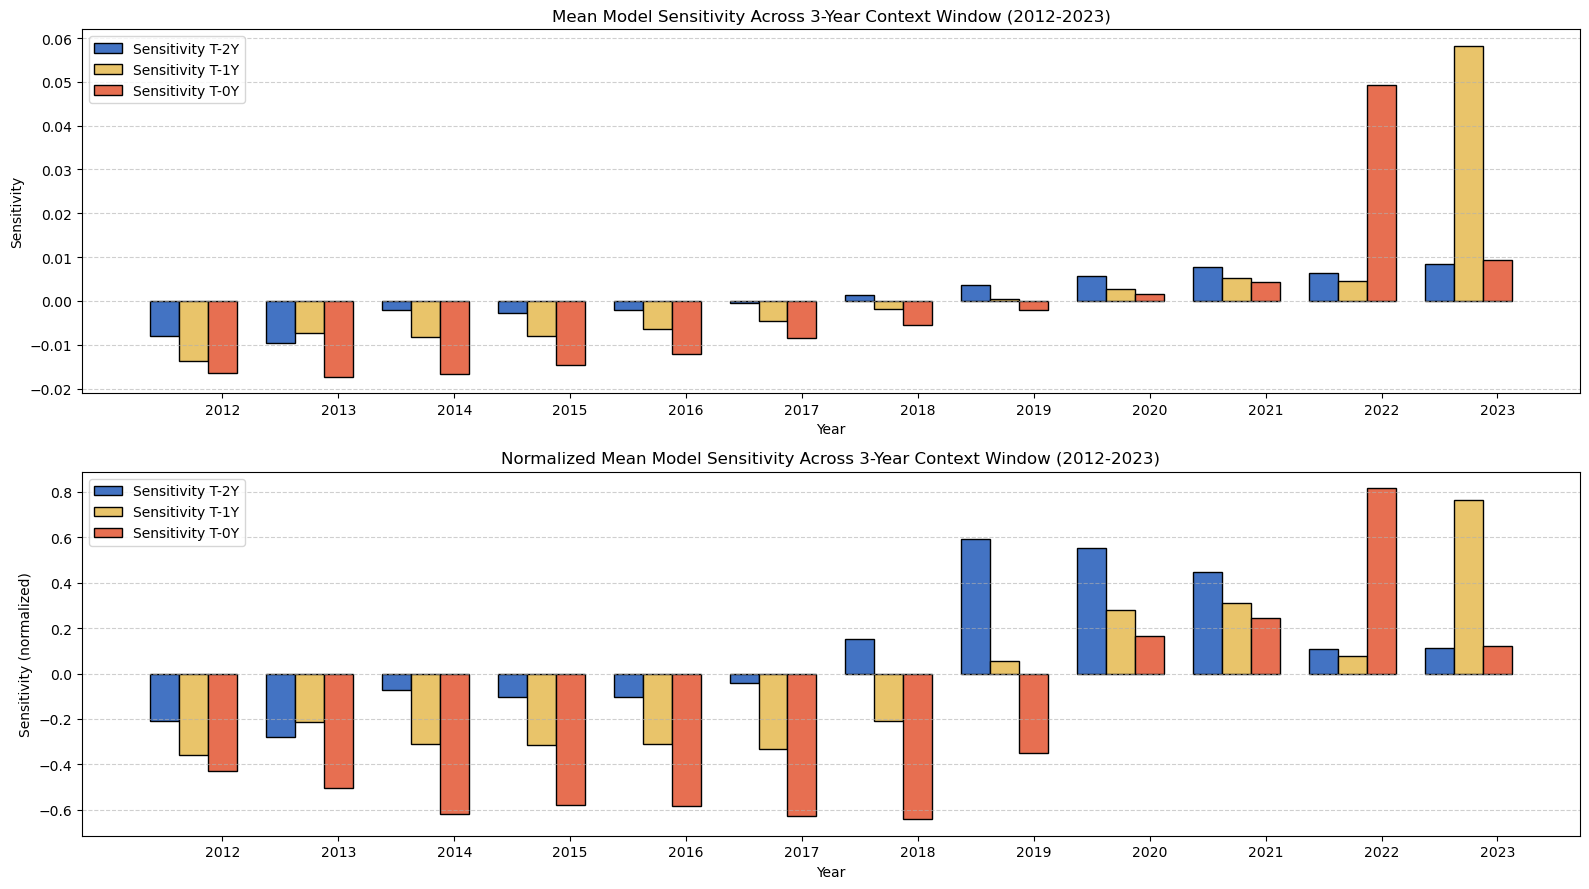

In [32]:
fig, ax = plt.subplots(2, 1, figsize=(16, 9))
ax = ax.flatten()

width = 0.25

ax[0].bar(years,             mean_window_sensitivity[:, 0], width, label='Sensitivity T-2Y', color='#4373c3',    edgecolor="black")
ax[0].bar(years + width,     mean_window_sensitivity[:, 1], width, label='Sensitivity T-1Y', color='#e9c46a', edgecolor="black")
ax[0].bar(years + 2 * width, mean_window_sensitivity[:, 2], width, label='Sensitivity T-0Y', color='#e76f51',     edgecolor="black")

ax[0].legend(loc='upper left')

ax[0].grid(True, axis='y', linestyle='--', alpha=0.6)

ax[0].set_title("Mean Model Sensitivity Across 3-Year Context Window (2012-2023)")
ax[0].set_xlabel("Year")
ax[0].set_ylabel("Sensitivity")

ax[0].set_xticks(years + 2 * width)
ax[0].set_xticklabels(years)

ax[1].bar(years,             norm_mean_window_sensitivity[:, 0], width, label='Sensitivity T-2Y', color='#4373c3',    edgecolor="black")
ax[1].bar(years + width,     norm_mean_window_sensitivity[:, 1], width, label='Sensitivity T-1Y', color='#e9c46a', edgecolor="black")
ax[1].bar(years + 2 * width, norm_mean_window_sensitivity[:, 2], width, label='Sensitivity T-0Y', color='#e76f51',     edgecolor="black")

ax[1].legend(loc='upper left')

ax[1].grid(True, axis='y', linestyle='--', alpha=0.6)

ax[1].set_title("Normalized Mean Model Sensitivity Across 3-Year Context Window (2012-2023)")
ax[1].set_xlabel("Year")
ax[1].set_ylabel("Sensitivity (normalized)")

ax[1].set_xticks(years + 2 * width)
ax[1].set_xticklabels(years)

fig.tight_layout()

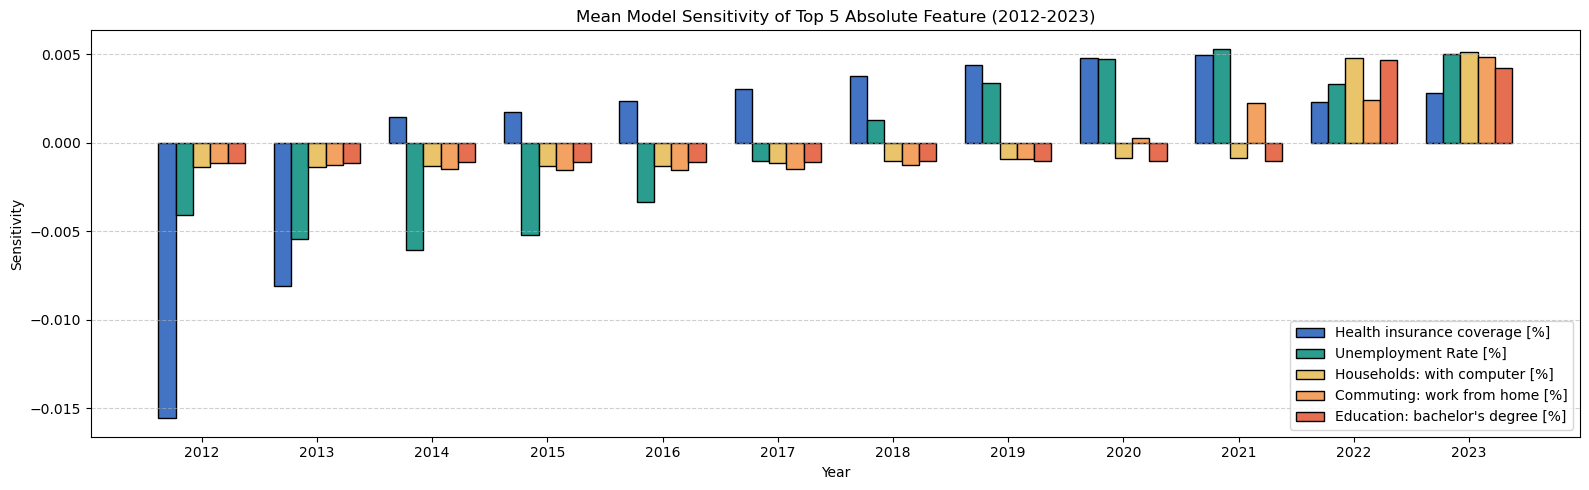

In [33]:
fig, ax = plt.subplots(1, figsize=(16, 5))

width = 0.15

ax.bar(years,             mean_feature_sensitivity[:, idx[0]], width, label=features[idx[0]], color='#4373c3',    edgecolor="black")
ax.bar(years + width,     mean_feature_sensitivity[:, idx[1]], width, label=features[idx[1]], color='#2a9d8f', edgecolor="black")
ax.bar(years + 2 * width, mean_feature_sensitivity[:, idx[2]], width, label=features[idx[2]], color='#e9c46a',     edgecolor="black")
ax.bar(years + 3 * width, mean_feature_sensitivity[:, idx[3]], width, label=features[idx[3]], color='#f4a261',     edgecolor="black")
ax.bar(years + 4 * width, mean_feature_sensitivity[:, idx[4]], width, label=features[idx[4]], color='#e76f51',     edgecolor="black")

ax.legend(loc='lower right')

ax.grid(True, axis='y', linestyle='--', alpha=0.6)

ax.set_title("Mean Model Sensitivity of Top 5 Absolute Feature (2012-2023)")
ax.set_xlabel("Year")
ax.set_ylabel("Sensitivity")

ax.set_xticks(years + 2 * width)
ax.set_xticklabels(years)

fig.tight_layout()

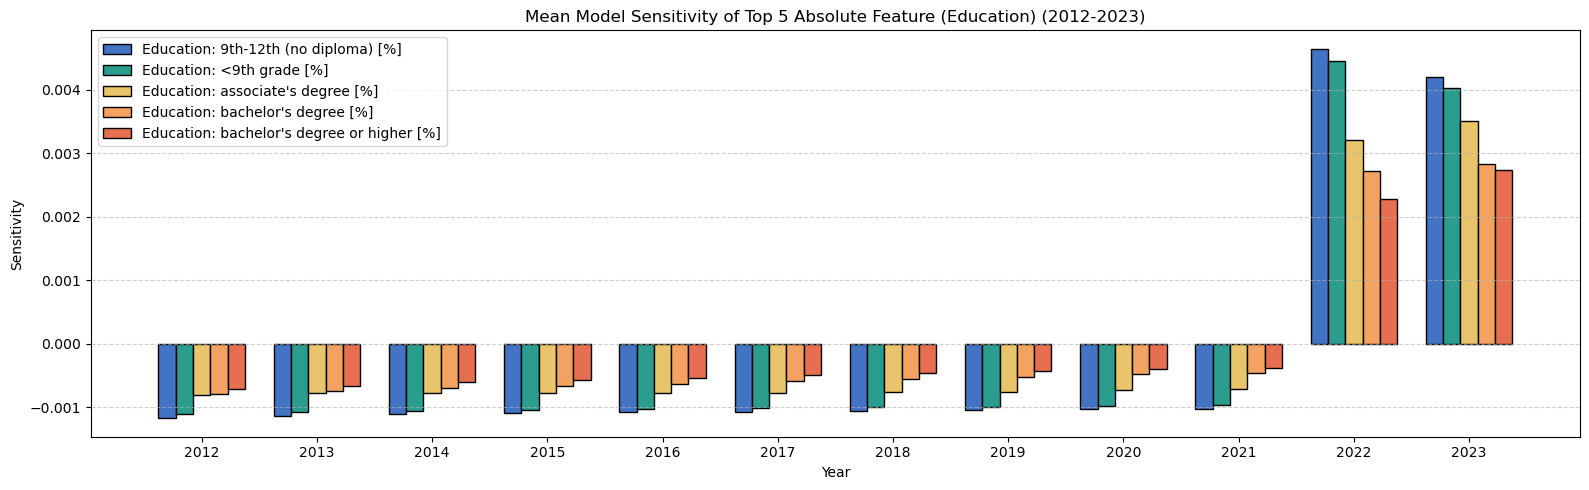

In [34]:
fig, ax = plt.subplots(1, figsize=(16, 5))

width = 0.15

ax.bar(years,             mean_feature_sensitivity[:, idx_edu[0]], width, label=features[13], color='#4373c3',    edgecolor="black")
ax.bar(years + width,     mean_feature_sensitivity[:, idx_edu[1]], width, label=features[14], color='#2a9d8f', edgecolor="black")
ax.bar(years + 2 * width, mean_feature_sensitivity[:, idx_edu[2]], width, label=features[15], color='#e9c46a',     edgecolor="black")
ax.bar(years + 3 * width, mean_feature_sensitivity[:, idx_edu[3]], width, label=features[16], color='#f4a261',     edgecolor="black")
ax.bar(years + 4 * width, mean_feature_sensitivity[:, idx_edu[4]], width, label=features[17], color='#e76f51',     edgecolor="black")

ax.legend(loc='upper left')

ax.grid(True, axis='y', linestyle='--', alpha=0.6)

ax.set_title("Mean Model Sensitivity of Top 5 Absolute Feature (Education) (2012-2023)")
ax.set_xlabel("Year")
ax.set_ylabel("Sensitivity")

ax.set_xticks(years + 2 * width)
ax.set_xticklabels(years)

fig.tight_layout()

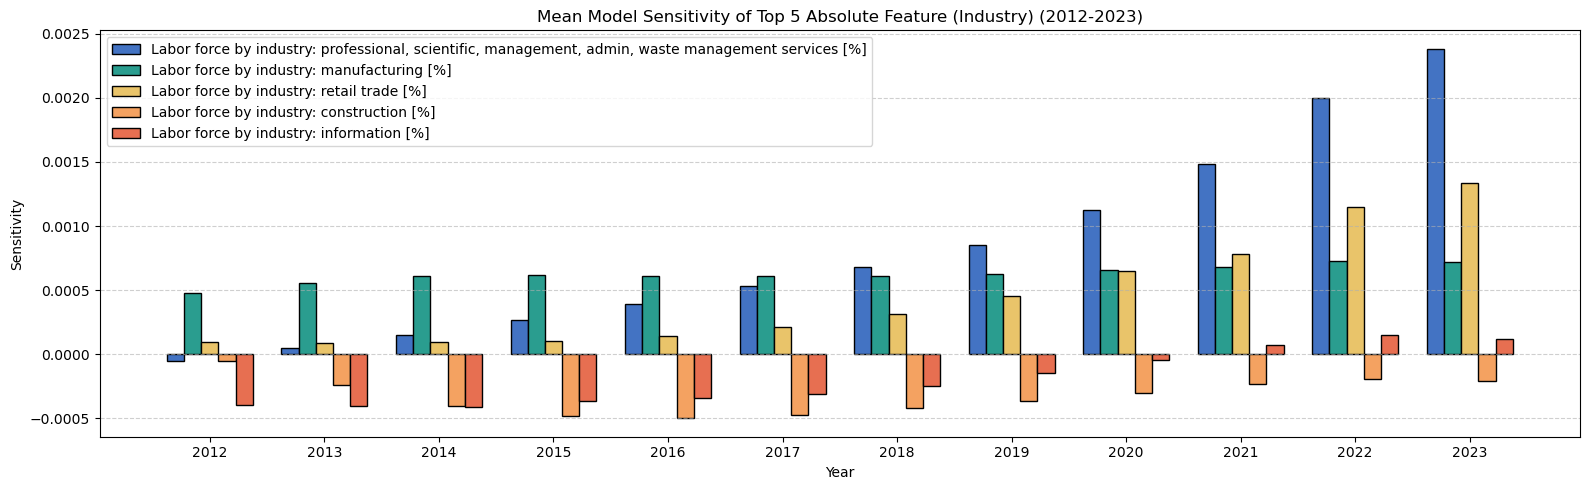

In [35]:
fig, ax = plt.subplots(1, figsize=(16, 5))

width = 0.15

ax.bar(years + 0 * width, mean_feature_sensitivity[:, idx_ind[0]], width, label=features[idx_ind[0]], color='#4373c3',     edgecolor="black")
ax.bar(years + 1 * width, mean_feature_sensitivity[:, idx_ind[1]], width, label=features[idx_ind[1]], color='#2a9d8f',     edgecolor="black")
ax.bar(years + 2 * width, mean_feature_sensitivity[:, idx_ind[2]], width, label=features[idx_ind[2]], color='#e9c46a',     edgecolor="black")
ax.bar(years + 3 * width, mean_feature_sensitivity[:, idx_ind[3]], width, label=features[idx_ind[3]], color='#f4a261',     edgecolor="black")
ax.bar(years + 4 * width, mean_feature_sensitivity[:, idx_ind[4]], width, label=features[idx_ind[4]], color='#e76f51',     edgecolor="black")

ax.legend(loc='upper left')

ax.grid(True, axis='y', linestyle='--', alpha=0.6)

ax.set_title("Mean Model Sensitivity of Top 5 Absolute Feature (Industry) (2012-2023)")
ax.set_xlabel("Year")
ax.set_ylabel("Sensitivity")

ax.set_xticks(years + 2 * width)
ax.set_xticklabels(years)

fig.tight_layout()